<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.clustering-and-anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram

--2020-04-01 11:47:55--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py’

andrea_models.py    100%[===================>]   3.12K  --.-KB/s    in 0s      

2020-04-01 11:47:55 (60.2 MB/s) - ‘andrea_models.py’ saved [3190/3190]

--2020-04-01 11:47:57--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request s

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Let's fix the random seed. In Python, setting a seed is [a mess](https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752) ([2](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/), [3](https://github.com/scikit-learn/scikit-learn/issues/10237) )

In [0]:
np.random.seed(9)
random.seed(9)

**Goal**: 
Find fraudolent credit card transactions

**Dataset**:
* From [DataHub](https://datahub.io/machine-learning/creditcard)
* Anonimized transactions
* Features have no precise meaning: obtained via Principal Component Analysis (PCA)
* Ground truth: transactions labeled as normal/anomaly

In [3]:
! wget https://datahub.io/machine-learning/creditcard/r/creditcard.csv

--2020-04-01 11:48:06--  https://datahub.io/machine-learning/creditcard/r/creditcard.csv
Resolving datahub.io (datahub.io)... 104.18.49.253, 104.18.48.253, 2606:4700:3033::6812:31fd, ...
Connecting to datahub.io (datahub.io)|104.18.49.253|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv [following]
--2020-04-01 11:48:07--  https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.18.48.253, 104.18.49.253, 2606:4700:3031::6812:30fd, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.18.48.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151114991 (144M) [text/csv]
Saving to: ‘creditcard.csv’

creditcard.csv      100%[===================>] 144.11M   119MB/s    in 1

In [4]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'


In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
df['Class'].value_counts()

'0'    284315
'1'       492
Name: Class, dtype: int64

The anomalies are the minority.

In [7]:
num_of_normal = sum( df['Class']=="'0'" )
num_of_anomalies = sum( df['Class']=="'1'" )
num_of_anomalies/num_of_normal

0.0017304750013189597

Remove the time, since it has no meaning for discovering anomalies for us.

In [0]:
df = df.drop('Time', axis=1)

We put the label aside

In [0]:
X = df.drop('Class', axis=1)
y = df['Class']

All the methods we will use, except iForests, performs best if the dataset is scaled

In [0]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means clustering

Before detecting anomalies, look for a "good" clustering.

Start with K=3 clusters.

In [0]:
K =3
model = KMeans(n_clusters=K)
clusters = model.fit_predict(X_scaled)

The array "`clusters`" contains the cluster id of each sample

In [12]:
clusters[0:5]

array([2, 2, 1, 1, 2], dtype=int32)

Check how many elements per cluster

(array([ 20308.,      0.,      0.,      0.,      0.,  40453.,      0.,
             0.,      0., 224046.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

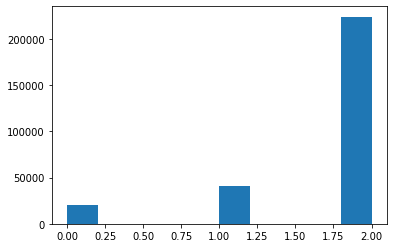

In [13]:
plt.hist(clusters)

Inertia (sum of squared distances between a sample and its centroid)

In [14]:
model.inertia_

7689781.829537551

### Random initializations

In sklearn, Kmeans algorithm is repeated `n_init` times (by default 10), so to produce 10 models. The model with the smallest inertia is selected.

How to know if `n_init` is enough or we should increase it? Intuitively, the more the dimensions (features), the more random initializations we would need.

Suggestion: Repeat KMeans many times, increasing `n_init` until you see that the inertia stops improving.

To go fast, do this on a smaller subset.

In [0]:
n_samples = 10000
X_sub = subsample(X_scaled, n_samples)

Inertia with  10  initializations
Inertia with  20  initializations
Inertia with  30  initializations
Inertia with  40  initializations
Inertia with  50  initializations
Inertia with  60  initializations
Inertia with  70  initializations
Inertia with  80  initializations
Inertia with  90  initializations
Inertia with  100  initializations
Inertia with  110  initializations
Inertia with  120  initializations
Inertia with  130  initializations
Inertia with  140  initializations
Inertia with  150  initializations
Inertia with  160  initializations
Inertia with  170  initializations
Inertia with  180  initializations
Inertia with  190  initializations


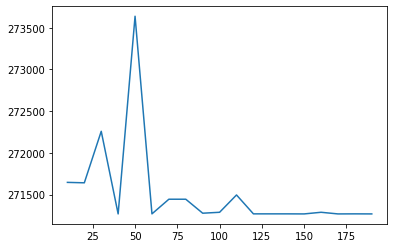

In [18]:
inertia_values = []

repeats = range(10, 200, 10)

for r in repeats:
  model = KMeans(K, n_init=r)
  model.fit_predict(X_sub)
  inertia_values.append(model.inertia_)
  print("Inertia with ", r, " initializations:", model.inertia_)

plt.plot(repeats, inertia_values)

It seems that 80 repeats should be enough

In [0]:
n_init = 80

### Silhouette

To evaluate the goodness of clustering, we compute the silhouette score 

=> Infeasible on the entire dataset!

Recall that you need to compute the distances between all samples, i.e.

In [19]:
print("Distances to be computed: ", "{:e}".format( X_scaled.shape[0]**2) )

Distances to be computed:  8.111503e+10
ERROR! Session/line number was not unique in database. History logging moved to new session 59


We will just check the silhouette on a random subset of samples.

In [0]:
model = KMeans(K, n_init=n_init)
clusters = model.fit_predict(X_sub)

In [25]:
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X_sub, clusters)
silhouette_avg



0.09978408724036514

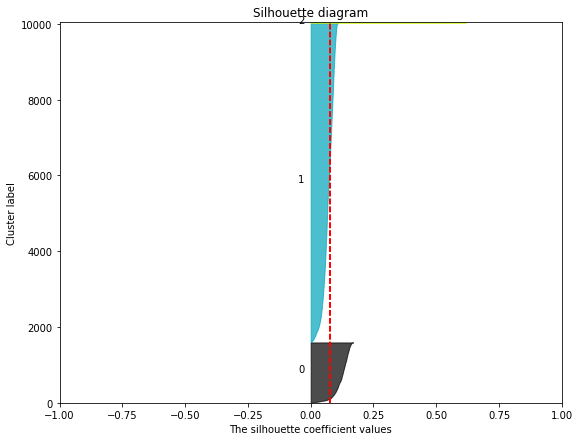

In [26]:
sample_silhouette_values = silhouette_diagram(X_sub, clusters, K)


Clustering is bad:
* The silhouette score is << 1 
* Sample silhouette values are quite low.
* Cluster 2 seems useless


Let's check other values of K

For K= 2  the silhouette score is  0.925586669964095
For K= 3  the silhouette score is  0.10501549814704954
For K= 4  the silhouette score is  0.06404847162012177
For K= 5  the silhouette score is  0.07445332779021446
For K= 6  the silhouette score is  0.07042610581362005
For K= 7  the silhouette score is  0.07586216289698637
For K= 8  the silhouette score is  0.07785556968187658
For K= 9  the silhouette score is  0.05538472540619306
For K= 10  the silhouette score is  0.07427030301988079
For K= 11  the silhouette score is  0.061353863210523954


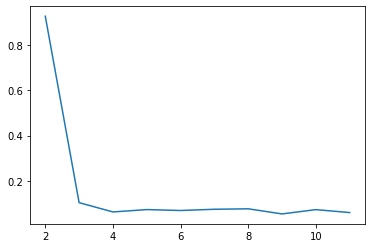

In [27]:
max_clusters = 12

scores = []

for K in range (2,max_clusters):
  # To avoid using always the same seed, let's change the random state every time
  model = KMeans(K, n_init=n_init)
  clusters = model.fit_predict(X_sub)

  silhouette_avg = silhouette_score(X_sub, clusters)
  scores.append(silhouette_avg)
  print ("For K=",K, " the silhouette score is ", silhouette_avg)

plt.plot(range (2,max_clusters), scores)

The best silhouette score is for K=2

The hyperparameters we decide to use are:


In [0]:
K=2
n_init = 80

Note that we did not need to separete training and test set, as we have **ignored ground truth** and all the metrics we observe are just based on features.

# Anomaly detection

In [40]:
model = KMeans(K, n_init=n_init)
clusters = model.fit_predict(X_sub)
sample_scores = model.transform(X_sub).min(axis=1)

array([4.53887404, 5.50296559, 3.4354573 , ..., 4.18832706, 3.66512483,
       6.94254636])

# Todo

Check:
* https://medium.com/datadriveninvestor/credit-card-fraud-detection-using-local-outlier-factor-and-isolation-forest-in-python-56edd0a44af5
* https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf